In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import glob
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score
fft_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=64e-6)
freq_res = 1/(T_obs*60)

2023-07-21 10:57:52.945740: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
input_shape = [800,1]
snr_group = 1
cur_dir = ''
run = 'runBD'
root_dir = ''

X_train = np.load(cur_dir + f'raw_data/{run}/train_data_classifier_{input_shape[0]}.npy').astype(np.float64)
X_test = np.load(cur_dir + f'raw_data/{run}/test_data_classifier_{input_shape[0]}.npy').astype(np.float64)
X_val = np.load(cur_dir + f'raw_data/{run}/val_data_classifier_{input_shape[0]}.npy').astype(np.float64)
X_train = X_train/np.max(X_train,axis=1)[:,None]
X_test = X_test/np.max(X_test,axis=1)[:,None]
X_val = X_val/np.max(X_val,axis=1)[:,None]

Y_train = np.load(cur_dir + f'raw_data/{run}/train_labels_classifier_{input_shape[0]}.npy').astype(np.float64)
Y_test = np.load(cur_dir + f'raw_data/{run}/test_labels_classifier_{input_shape[0]}.npy').astype(np.float64)
Y_val = np.load(cur_dir + f'raw_data/{run}/val_labels_classifier_{input_shape[0]}.npy').astype(np.float64)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1) 

Y_train = (Y_train.reshape(Y_train.shape[0],1))
Y_val = (Y_val.reshape(Y_val.shape[0],1))
Y_test = (Y_test.reshape(Y_test.shape[0],1))


train_indices = np.load(cur_dir + f'raw_data/{run}/train_indices_classifier_{input_shape[0]}.npy')
test_indices = np.load(cur_dir + f'raw_data/{run}/test_indices_classifier_{input_shape[0]}.npy')
val_indices = np.load(cur_dir + f'raw_data/{run}/val_indices_classifier_{input_shape[0]}.npy')


In [3]:

def find_indices(small_list, big_list):
    indices = []

    for item in small_list:
        if item in big_list:
            index_list = np.where(big_list == item)
            indices.extend(index_list[0])

    return indices

if snr_group != -1:

    labels_df = pd.read_csv(root_dir + f'meta_data/labels_{run}.csv')
    snr_range = labels_df['fold_snr_theory'].values
    #snr_bins = np.array([0 , 0.068, 0.126, 0.184, 0.242, 0.3  ])
    snr_bins = np.array([0 , 5, 30])

    train_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'train')].values
    test_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'test')].values
    val_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'val')].values

    train_indices_small = find_indices(train_indices_group, train_indices)
    test_indices_small = find_indices(test_indices_group, test_indices)
    val_indices_small = find_indices(val_indices_group, val_indices)

    X_train = X_train[train_indices_small]
    X_test = X_test[test_indices_small]
    X_val = X_val[val_indices_small]

    Y_train = Y_train[train_indices_small]
    Y_test = Y_test[test_indices_small]
    Y_val = Y_val[val_indices_small]

    train_indices = train_indices[train_indices_small]
    test_indices = test_indices[test_indices_small]
    val_indices = val_indices[val_indices_small]

    

In [5]:
# find 0 and 1 indices in Y_train
Y_train_0 = np.where(Y_train == 0)[0]
Y_train_1 = np.where(Y_train == 1)[0]
Y_train_01 = np.concatenate((Y_train_0, Y_train_1), axis=0)
np.random.shuffle(Y_train_01)
Y_train = Y_train[Y_train_01]
X_train = X_train[Y_train_01]
train_indices = train_indices[Y_train_01]

# find 0 and 1 indices in Y_val
Y_val_0 = np.where(Y_val == 0)[0]
Y_val_1 = np.where(Y_val == 1)[0]
Y_val_01 = np.concatenate((Y_val_0, Y_val_1), axis=0)
np.random.shuffle(Y_val_01)
Y_val = Y_val[Y_val_01]
X_val = X_val[Y_val_01]
val_indices = val_indices[Y_val_01]

# find 0 and 1 indices in Y_test
Y_test_0 = np.where(Y_test == 0)[0]
Y_test_1 = np.where(Y_test == 1)[0]
Y_test_01 = np.concatenate((Y_test_0, Y_test_1), axis=0)
np.random.shuffle(Y_test_01)
Y_test = Y_test[Y_test_01]
X_test = X_test[Y_test_01]
test_indices = test_indices[Y_test_01]


In [6]:
cur_dir = ''
run = 'runBD'
#test_indices = np.load(cur_dir + f'raw_data/{run}/test_indices_classifier_{input_shape[0]}.npy')
labels_df = pd.read_csv(cur_dir + f'meta_data/labels_{run}.csv')
#test_indices_classifier = np.load(cur_dir + f'raw_data/{run}/test_indices_classifier_{input_shape[0]}.npy')

In [7]:
def period_accuracy(y_true, y_pred):
    # Ensure the predictions are the same shape as the true values
    assert y_true.shape == y_pred.shape
    return accuracy_score(y_true, y_pred)

In [8]:
# Load the best model after training
best_model = tf.keras.models.load_model("models/chunk_classify_attention_2528257_checkpoint.h5")

2023-07-21 10:58:18.081333: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-21 10:58:18.082604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-21 10:58:18.661149: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-21 10:58:18.661231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules11): /proc/driver/nvidia/version does not exist
2023-07-21 10:58:18.662950: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [9]:
X_test.shape

(2664, 800, 1)

In [10]:
Y_pred = best_model.predict(X_test)

2023-07-21 10:58:28.787108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-21 10:58:28.787583: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


In [11]:
Y_pred.shape

(2664, 2)

In [12]:
Y_pred

array([[7.7320373e-01, 2.2679630e-01],
       [8.0599993e-01, 1.9400004e-01],
       [7.6451993e-01, 2.3548009e-01],
       ...,
       [8.2085258e-01, 1.7914741e-01],
       [1.0968090e-06, 9.9999893e-01],
       [1.2555714e-04, 9.9987447e-01]], dtype=float32)

In [13]:
Y_pred2 = np.argmax(Y_pred, axis=-1)

In [14]:
Y_pred2 = Y_pred2.reshape(Y_pred.shape[0],1)

In [15]:
accuracy = period_accuracy(Y_test, Y_pred2)
print("Period accuracy: ", accuracy)

Period accuracy:  0.8115615615615616


In [16]:
def classify(y_scores, threshold):
    return np.array([1 if score >= threshold else 0 for score in y_scores]).reshape(Y_test.shape)
#Y_pred3 = classify(Y_pred[:,1], 0.2)

In [17]:
from sklearn.metrics import roc_curve, auc
# Assuming clf is your trained classifier and X_test is your test data
y_scores = Y_pred[:,1] # get the probability of the positive class

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)

# Now let's find the threshold where the true positive rate (tpr) is maximum
optimal_idx = np.argmax(tpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold: ", optimal_threshold)

Optimal threshold:  0.08396078


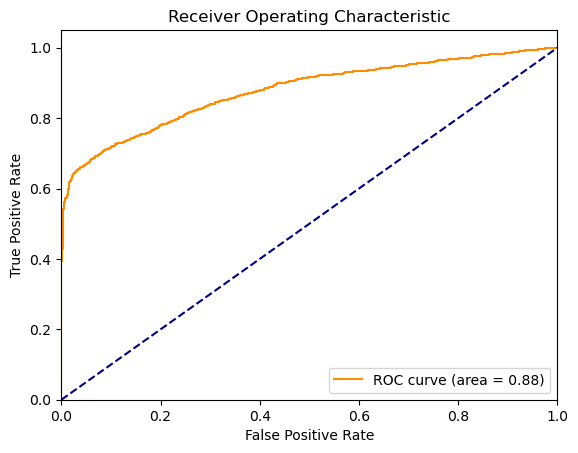

In [18]:
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred2).ravel()

print('True Positives: ', tp)
print('True Negatives: ', tn)
print('False Positives: ', fp)
print('False Negatives: ', fn)


True Positives:  941
True Negatives:  1221
False Positives:  111
False Negatives:  391


In [15]:
def signal_detect_accuracy(Y_test,Y_pred):
    signals = np.zeros_like(Y_test) + 1
    non_detections = np.where(Y_test == 0)[0]
    signals[non_detections] = 0
    
    signals_pred = np.zeros_like(Y_pred) + 1
    non_detections_pred = np.where(Y_pred == 0)[0]
    signals_pred[non_detections_pred] = 0
    
    return signals, signals_pred

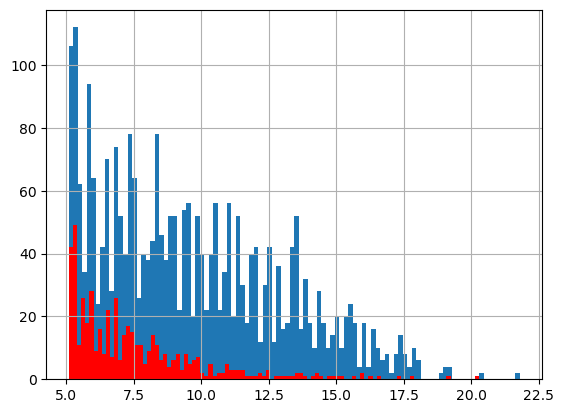

In [36]:
labels_df['fold_snr_theory'].loc[test_indices].hist(bins=100)
misclassified = (Y_test != Y_pred2)
test_indices_misclassified = test_indices[misclassified[:,0]]
labels_df['fold_snr_theory'].loc[test_indices_misclassified].hist(bins=100,color='r')

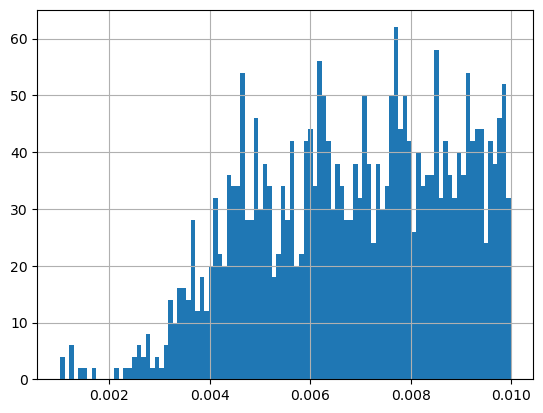

In [33]:
labels_df['snr'].loc[test_indices].hist(bins=100)

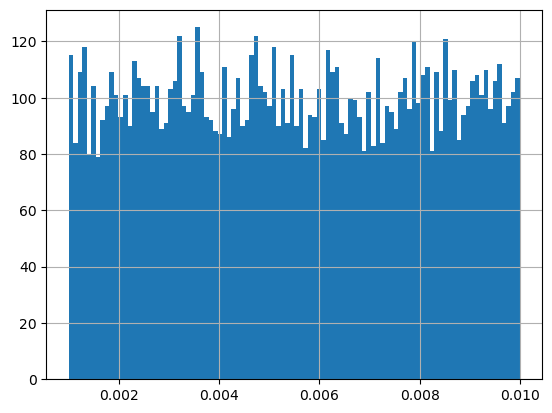

In [34]:
labels_df['snr'].hist(bins=100)

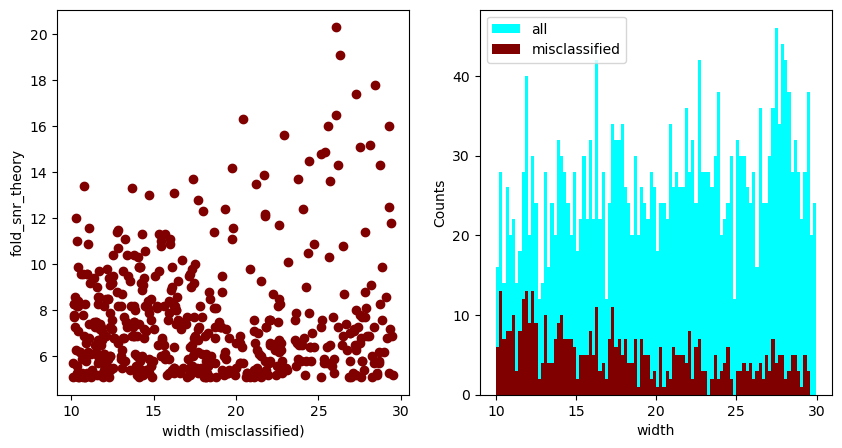

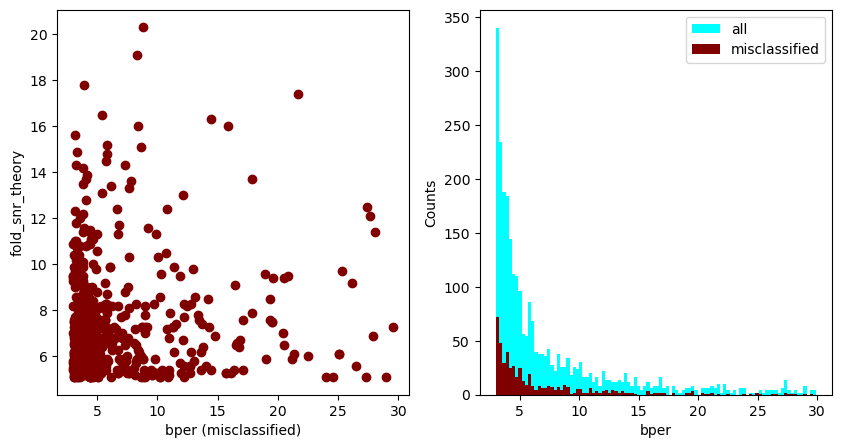

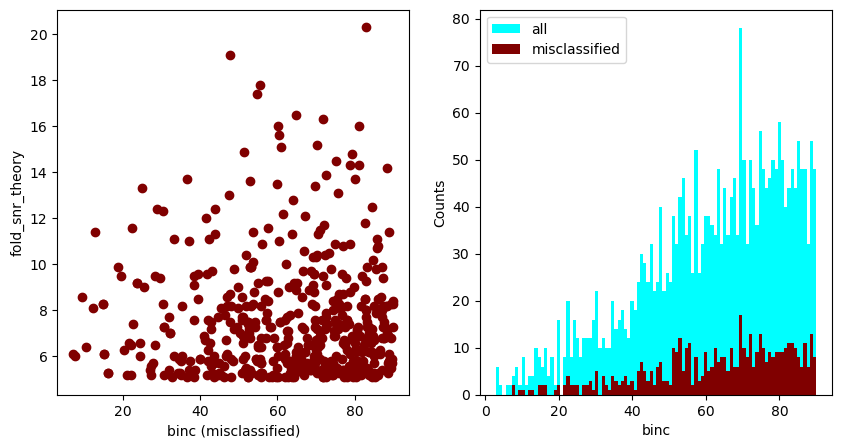

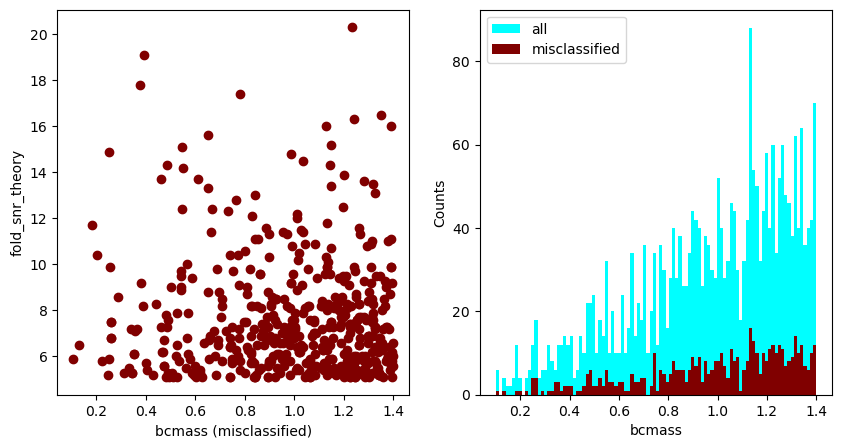

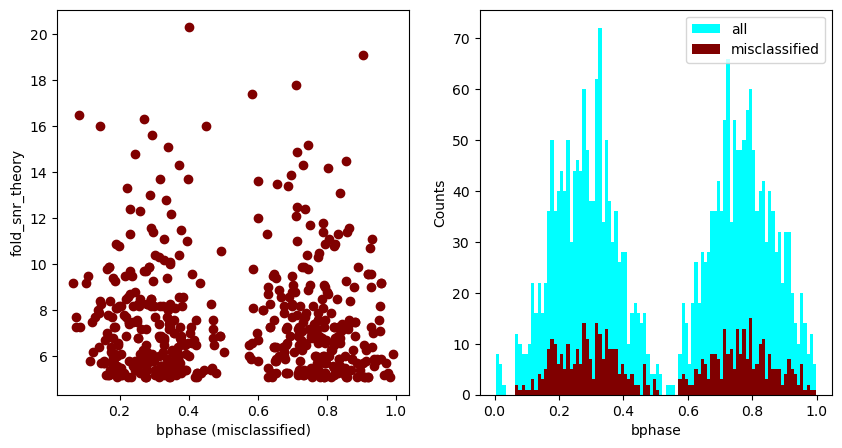

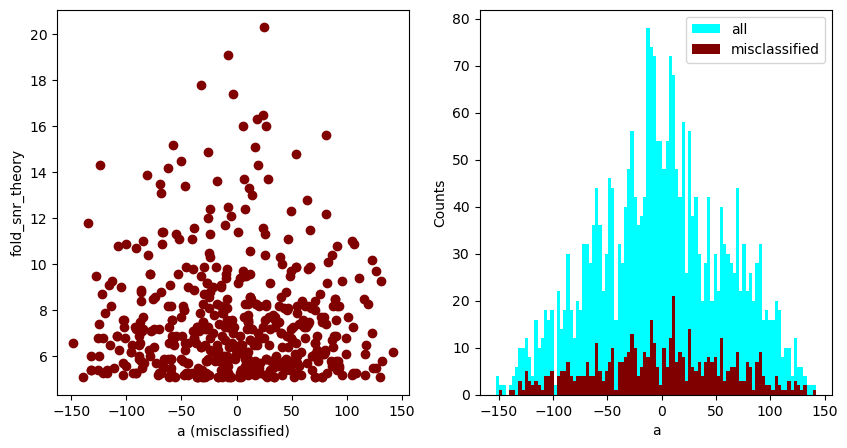

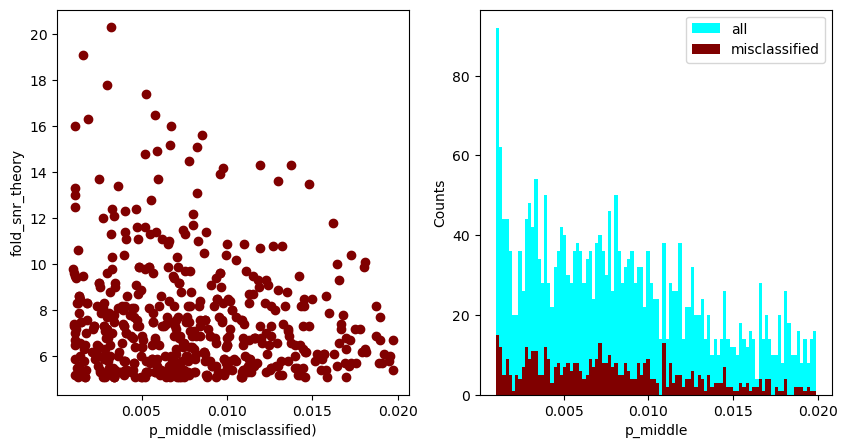

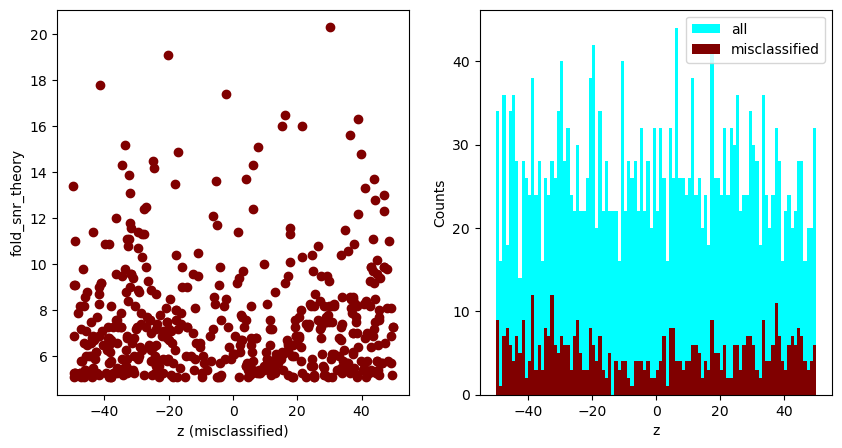

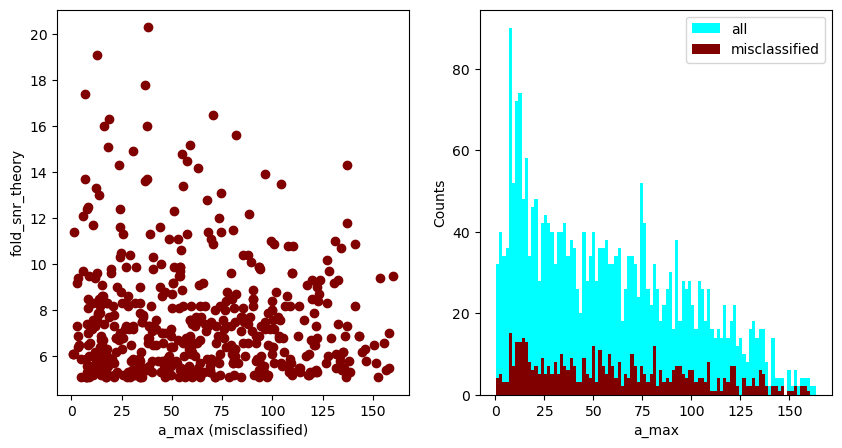

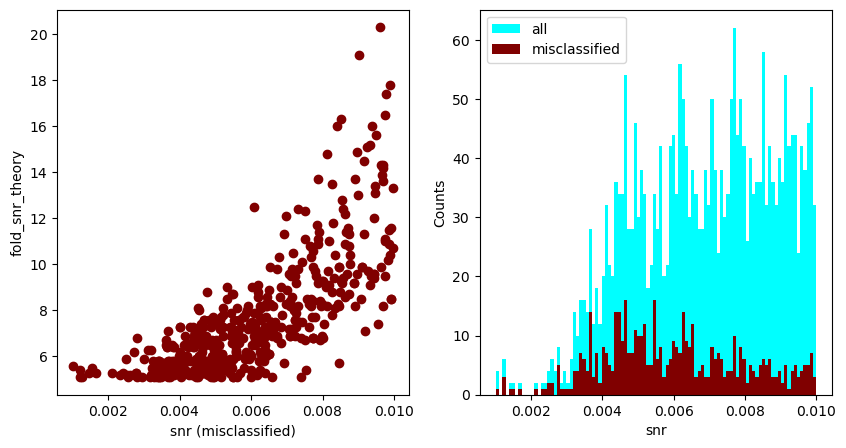

In [30]:
for col in ['width', 'bper', 'binc', 'bcmass',
       'bphase', 'a', 'p_middle', 'z', 'a_max',
       'snr']:
       #Make 2 subplots
       X_df = labels_df[col].loc[test_indices]
       fig, axs = plt.subplots(1, 2, figsize=(10, 5))
       _ = axs[1].hist(X_df.values, bins=100,color='cyan',label='all')
       axs[1].set_xlabel(col)
       axs[1].set_ylabel('Counts')
       
       misclassified = (Y_test != Y_pred2)
       test_indices_misclassified = test_indices[misclassified[:,0]]
       X = labels_df[col].loc[test_indices_misclassified]
       Y = labels_df['fold_snr_theory'].values[test_indices_misclassified]


       axs[0].plot(X, Y, 'o',c='maroon')
       axs[0].set_xlabel(col+' (misclassified)')
       axs[0].set_ylabel('fold_snr_theory')
       #axs[0].set_ylim(0,1000)
       _ = axs[1].hist(X, bins=_[1],color='maroon',label='misclassified')
       axs[1].set_xlabel(col)
       axs[1].set_ylabel('Counts')
       plt.legend()
       plt.show()
       plt.close()